In [19]:
!pip install nltk

In [20]:
import nltk
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from wordcloud import WordCloud

# Preprocessing and evaluation
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l1, l2

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
df = pd.read_csv('/content/drive/MyDrive/Dataset_Movie/movie.csv')
df.head()

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


<ipython-input-25-5c3aa8d1b110>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='flare').set_title('Rating Distribution Across Dataset')


Text(0.5, 1.0, 'Rating Distribution Across Dataset')

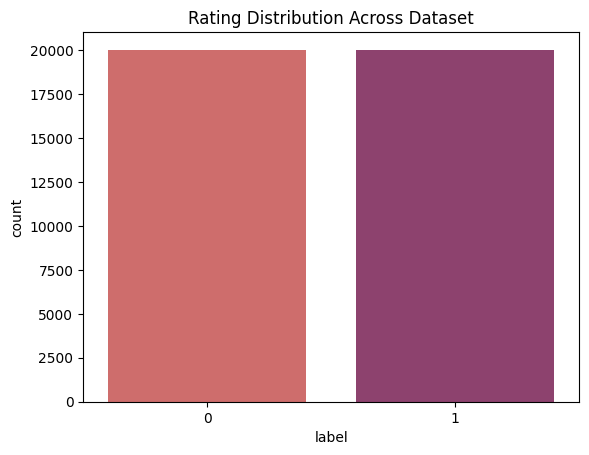

In [25]:
sns.countplot(data=df, x='label', palette='flare').set_title('Rating Distribution Across Dataset')

In [26]:
df['Length'] = df['text'].apply(len)
df.head()

,text,label,Length
0,I grew up (b. 1965) watching and loving the Th...,0,874
1,"When I put this movie in my DVD player, and sa...",0,1811
2,Why do people who do not know what a particula...,0,983
3,Even though I have great interest in Biblical ...,0,351
4,Im a die hard Dads Army fan and nothing will e...,1,983


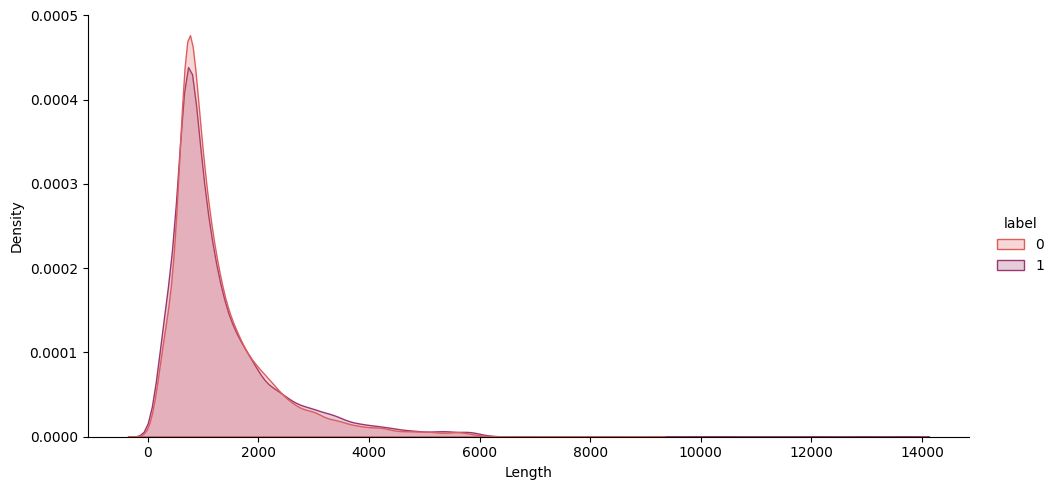

In [27]:
sns.displot(data=df, x='Length', hue='label', palette='flare', kind='kde', fill=True, aspect=2)

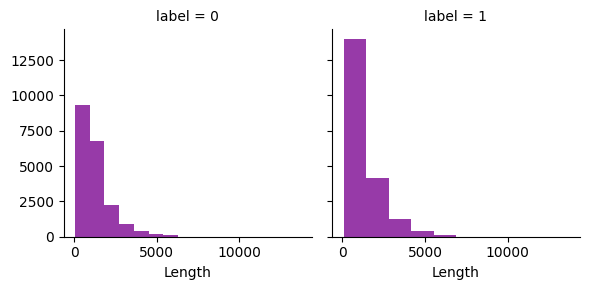

In [28]:
g = sns.FacetGrid(data=df, col='label')
g.map(plt.hist, 'Length', color='#973aa8')

<ipython-input-29-036e7b70837e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.stripplot(data=df, x='label', y='Length', palette='flare', alpha=0.3)


<Axes: xlabel='label', ylabel='Length'>

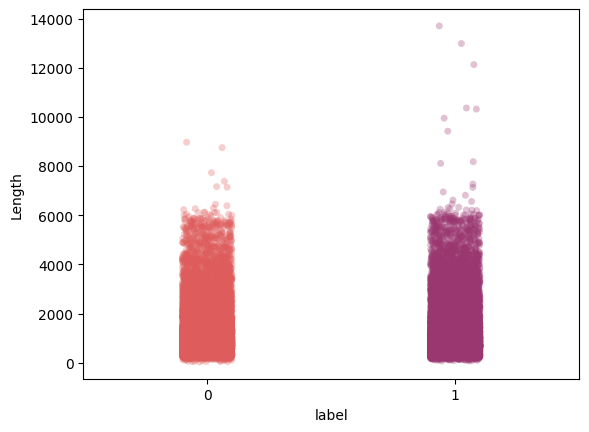

In [29]:
sns.stripplot(data=df, x='label', y='Length', palette='flare', alpha=0.3)

In [30]:
def rating(score):
    if score == 1:
        return 'Positive'
    else:
        return 'negative'

In [31]:
df['label'] = df['label'].apply(rating)

In [32]:
df.head()

,text,label,Length
0,I grew up (b. 1965) watching and loving the Th...,negative,874
1,"When I put this movie in my DVD player, and sa...",negative,1811
2,Why do people who do not know what a particula...,negative,983
3,Even though I have great interest in Biblical ...,negative,351
4,Im a die hard Dads Army fan and nothing will e...,Positive,983


In [33]:
length = df['Length'].sum()

In [34]:
print('Original:')
print(df['text'][0])
print()

sentence = []
for word in df['text'][0].split():
    stemmer = SnowballStemmer('english')
    sentence.append(stemmer.stem(word))
print('Stemming:')
print(' '.join(sentence))
print()

sentence = []
for word in df['text'][0].split():
    lemmatizer = WordNetLemmatizer()
    sentence.append(lemmatizer.lemmatize(word, 'v'))
print('Lemmatization:')
print(' '.join(sentence))

Original:
I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.

Stemming:
i grew up (b. 1965) watch and love the thunderbirds. all my mate at school watched. we play "thunderbird

In [35]:
def cleaning(text):
    #remove punctuations and uppercase
    clean_text = text.translate(str.maketrans('','',string.punctuation)).lower()

    #remove stopwords
    clean_text = [word for word in clean_text.split() if word not in stopwords.words('english')]

    #lemmatize the word
    sentence = []
    for word in clean_text:
        lemmatizer = WordNetLemmatizer()
        sentence.append(lemmatizer.lemmatize(word, 'v'))

    return ' '.join(sentence)

In [36]:
df['text'] = df['text'].apply(cleaning)

In [37]:
df['Length'] = df['text'].apply(len)
new_length = df['Length'].sum()

print('Total text length before cleaning: {}'.format(length))
print('Total text length after cleaning: {}'.format(new_length))

Total text length before cleaning: 52411730
Total text length after cleaning: 32504054


In [38]:
df.to_csv('cleaned_df.csv', index=False)

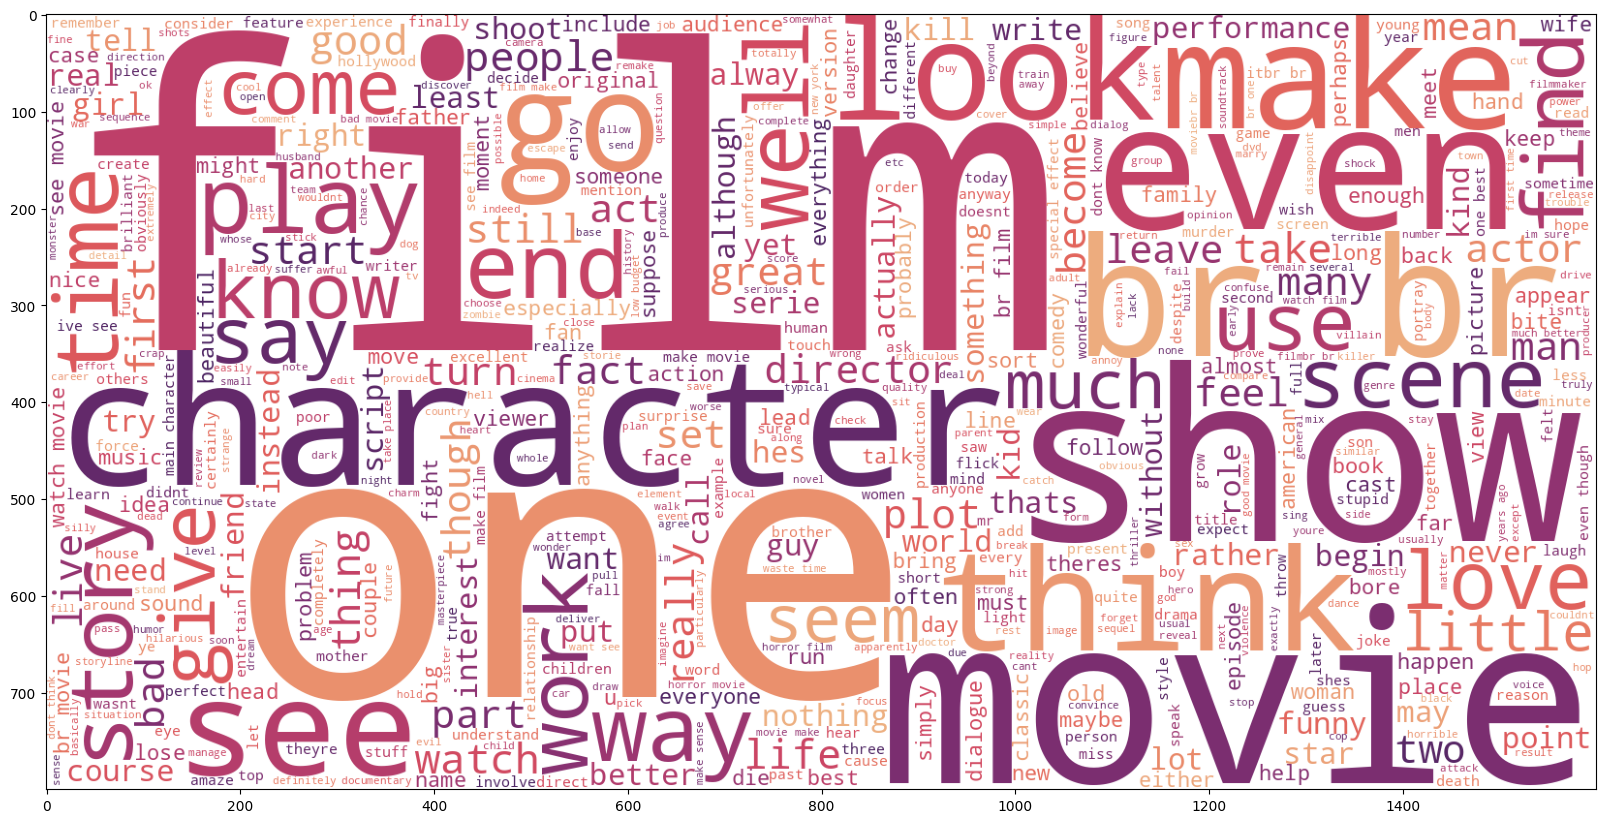

In [39]:
plt.figure(figsize=(20,20))
wc = WordCloud(max_words=1000, min_font_size=10,
                height=800,width=1600,background_color="white", colormap='flare').generate(' '.join(df['text']))

plt.imshow(wc)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2)

In [41]:
tfid = TfidfVectorizer()
train_tfid_matrix = tfid.fit_transform(X_train)
test_tfid_matrix = tfid.transform(X_test)

In [42]:
pickle.dump(tfid, open('tfidf.pkl', 'wb'))

In [43]:
models = [LogisticRegression(max_iter=1000),
          ]

In [44]:
accuracy = []

for model in models:
    cross_val = cross_val_score(model, train_tfid_matrix, y_train, scoring='accuracy',
                               cv=StratifiedKFold(10)).mean()
    accuracy.append(cross_val)

In [45]:
models_name = ['LogisticRegression']

acc = pd.DataFrame({'Model': models_name, 'Accuracy': accuracy})
acc

,Model,Accuracy
0,LogisticRegression,0.889812


In [46]:
log = LogisticRegression(max_iter=1000)
log.fit(train_tfid_matrix, y_train)

pred = log.predict(test_tfid_matrix)

In [47]:
pickle.dump(log, open('ml_model.pkl', 'wb'))

In [48]:
ml = pickle.load(open('ml_model.pkl','rb'))
tfidf = pickle.load(open('tfidf.pkl','rb'))
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfidf.transform([clean_text])
    pred_proba = ml.predict_proba(tfid_matrix)
    idx = np.argmax(pred_proba)
    pred = ml.classes_[idx]

    return pred, pred_proba[0][idx]

ml_predict('poor room service')

('negative', 0.9517941856353622)

In [49]:
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[3525  411]
 [ 472 3592]]
              precision    recall  f1-score   support

    Positive       0.88      0.90      0.89      3936
    negative       0.90      0.88      0.89      4064

    accuracy                           0.89      8000
   macro avg       0.89      0.89      0.89      8000
weighted avg       0.89      0.89      0.89      8000



In [50]:
tokenizer = Tokenizer(num_words=50000, oov_token='<OOV>')

tokenizer.fit_on_texts(X_train)
# print(tokenizer.word_index)
total_word = len(tokenizer.word_index)
print('Total distinct words: {}'.format(total_word))

train_seq = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_seq)

test_seq = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_seq)

# One hot encoding the label
lb = LabelBinarizer()
train_labels = lb.fit_transform(y_train)
test_labels = lb.transform(y_test)

Total distinct words: 129130


In [51]:
pickle.dump(tokenizer, open('tokenizer.pkl', 'wb'))
pickle.dump(lb, open('label.pkl', 'wb'))

In [52]:
model = tf.keras.models.Sequential([tf.keras.layers.Embedding(total_word, 8),
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(8, kernel_regularizer=l2(0.001),
                                                          bias_regularizer=l2(0.001), activation='relu'),
                                    tf.keras.layers.Dropout(0.5),
                                    tf.keras.layers.Dense(3, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 8)           1033040   
                                                                 
 bidirectional (Bidirection  (None, 32)                3200      
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                        

In [66]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.fit(train_padded, train_labels, epochs=1, validation_data=(test_padded, test_labels), batch_size = 64)

500/500 [==============================] - 676s 1s/step - loss: 0.7372 - accuracy: 0.5032 - val_loss: 0.7015 - val_accuracy: 0.4920


<Axes: >

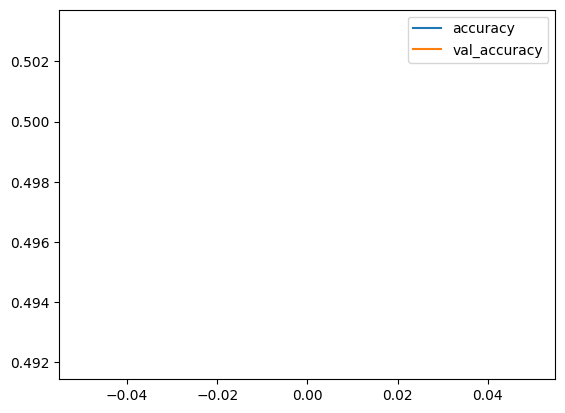

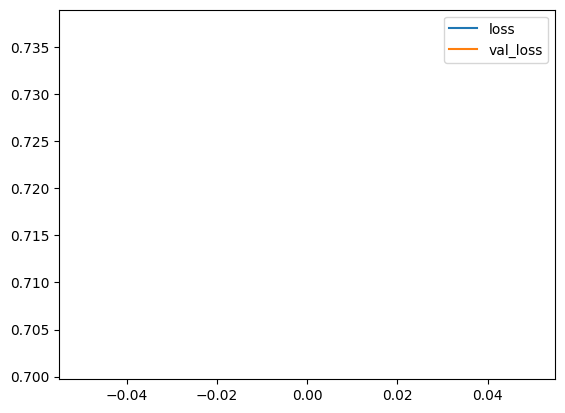

In [67]:
metrics = pd.DataFrame(model.history.history)
metrics[['accuracy', 'val_accuracy']].plot()
metrics[['loss', 'val_loss']].plot()

In [68]:
pred2 = model.predict(test_padded)

250/250 [==============================] - 40s 157ms/step


In [69]:
true_labels = np.argmax(test_labels, axis=-1)
pred_labels = np.argmax(pred2, axis=-1)

In [70]:
print(confusion_matrix(true_labels, pred_labels))
print(classification_report(true_labels, pred_labels))

[[8000]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8000

    accuracy                           1.00      8000
   macro avg       1.00      1.00      1.00      8000
weighted avg       1.00      1.00      1.00      8000



In [71]:
model.save('dl_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [72]:
# Logistic Regression
def ml_predict(text):
    clean_text = cleaning(text)
    tfid_matrix = tfid.transform([clean_text])
    pred = log.predict(tfid_matrix)[0]

    return pred

# Deep Neural Network
def dl_predict(text):
    clean_text = cleaning(text)
    seq = tokenizer.texts_to_sequences([clean_text])
    padded = pad_sequences(seq)

    pred = model.predict(padded)
    # Get the label name back
    result = lb.inverse_transform(pred)[0]

    return result

In [74]:
text = "I don't care if some people voted this movie to be bad. If you want the Truth this is a Very Good Movie! It has every thing a movie should have. You really should Get this one"

print('Prediction using Logistic Regression: {}'.format(ml_predict(text)))

Prediction using Logistic Regression: negative
